# Тема проекта: "Выбор локации для скважины"

**Описание проекта:** работая в добывающей компании «ГлавРосГосНефть», нужно решить, где бурить новую скважину. Для этого предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. 


**Цель проекта:** построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль; проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**План работы:**

1. **Загрузка и подготовка данных**

2. **Обучение и проверка модели  для каждого региона**:

 2.1. Разбивка данных на обучающую и валидационную выборки в соотношении 75:25.
 
 2.2. Обучение модели и получение предсказаний на валидационной выборке.
 
 2.3. Расчет среднего запаса предсказанного сырья и RMSE модели.
 
 2.4. Вывод
 
3.**Подготовка к расчёту прибыли**:

 3.1. Расчет достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение полученного объём сырья со средним запасом в каждом регионе. 
 
 3.2. Вывод
 
4. **Подготовка функции для расчёта прибыли по выбранным скважинам и предсказаниям модели**

 4.1. Расчет прибыли для полученного объёма сырья.
 
 
5. **Расчет рисков и прибыли для каждого региона**:

 5.1. Расчет распределения прибылис помощью техники Bootstrap с 1000 выборок.
 
 5.2. Расчет средней прибыли, 95%-го доверительного интервала и риска убытков. 
 
 5.3. Общий вывод: предложение для выбора региона.

**Описание данных:**

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).



In [1]:
# импортируем необходимые библиотеки

import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import numpy as np

from numpy.random import RandomState

from scipy import stats as st

import seaborn as sns

In [2]:
# ключевые значения для расчётов прибыли сохраним в отдельных переменных

REVENUE_UNIT = 450_000

REVENUE_BARREL = 450

BUDGET = 10_000_000_000 

COUNT = 200

## Загрузка и подготовка данных

In [3]:
# загружаем данные

data_0 = pd.read_csv('/datasets/geo_data_0.csv')

data_1 = pd.read_csv('/datasets/geo_data_1.csv')

data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
# выведем датафреймы на экран

display(data_0.head())

display(data_1.head())

display(data_2.head())

# посмотрим размеры датафреймов

display(data_0.shape)

display(data_1.shape)

display(data_2.shape)


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


(100000, 5)

(100000, 5)

(100000, 5)

Все три датафрейма состоят из 100 000 строк (объектов) и пяти столбцов(признаков), как и заявлено в условиях задачи. Все числа имеют неокругленные значения, но пока не понятно, как их можно округлить, оставим так.

In [5]:
# проверим информацию о датафреймах

print(data_0.info())

print(data_1.info())

print(data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

Пропущенные значения отсутствуют, то есть данные представлены в полном объеме, числовые значения имеют тип float64, а категориальные - object. Это устраивает. Посмотрим, нет ли явных дубликатов.

In [6]:
# проверим наличие явных дубликатов

display(data_0.duplicated().sum())

display(data_1.duplicated().sum())

display(data_2.duplicated().sum())

0

0

0

In [7]:
# проверим наличие дубликатов по ['id'], выведем их на экран

display(data_0[data_0['id'].duplicated()])

display(data_1[data_1['id'].duplicated()])

display(data_2[data_2['id'].duplicated()])



,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Явные дубликаты не обнаружены в данных, а неявные дубликаты с повторяющимися id обнаружены по всех трех датафреймах, зададим вопросы коллегам.

Разделим данные на признаки и целевой признак. В нашем случае признаками будут f0, f1, f2, а целевой признак - product — объём запасов в скважине (тыс. баррелей).

In [8]:
# разделим с помощью функций

def features_target(df):
    
    features = (df.drop(['product', 'id'], axis=1))
    
    target = (df['product']).astype(int)
    
    return features, target

features_0, target_0 = features_target(data_0)

features_1, target_1 = features_target(data_1)

features_2, target_2 = features_target(data_2)

# проверим разделение

features_0, target_0

(             f0        f1        f2
 0      0.705745 -0.497823  1.221170
 1      1.334711 -0.340164  4.365080
 2      1.022732  0.151990  1.419926
 3     -0.032172  0.139033  2.978566
 4      1.988431  0.155413  4.751769
 ...         ...       ...       ...
 99995  0.971957  0.370953  6.075346
 99996  1.392429 -0.382606  1.273912
 99997  1.029585  0.018787 -1.348308
 99998  0.998163 -0.528582  1.583869
 99999  1.764754 -0.266417  5.722849
 
 [100000 rows x 3 columns],
 0        105
 1         73
 2         85
 3        168
 4        154
         ... 
 99995    110
 99996    122
 99997     64
 99998     74
 99999    149
 Name: product, Length: 100000, dtype: int64)

Проверим статистические показатели признаков на предмет вылетов и аномальных значений.

In [9]:
# выведем информацию функцией describe

display(data_0.describe())

display(data_1.describe())

display(data_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


В первом регионе (data_0) медианы и средние признаков  примерно равны, можем предположить, что данные распределены нормально, однако, стандартное отклонение больше среднего, что может говорить об аномальных значениях. В показателях целевого признака ничего подозрительного нет.

Во втором регионе (data_1) медианы и средние признаков примерно равны, можем предположить, что данные распределены нормально. Но при этом стандартное отклонение признаков f0 и f1 намного больше средних, это может говорить о наличии аномальных значений. Что касается целевого признака, медиана примерно на 10% меньше среднего, что может говорить о наличии нескольких очень больших значений, стандартное отклонение меньше среднего, это хороший показатель данных.

В третьем регионе (data_2) медианы и средние признаков примерно равны, значит, можно говорить о нормальном распределении данных, но стандартное отклонение значительно больше среднего, что наоборот говорит о серьезных аномалиях в данных. Медиана и среднее целевого признака примерно равны, можно предположить нормальное распределение, стандартное отклонение в 2 раза меньше среднего, значит аномальных значений нет.

Наши выводы получились довольно сумбурные, проверим, что нам покажет диаграмма размаха.

<AxesSubplot:>

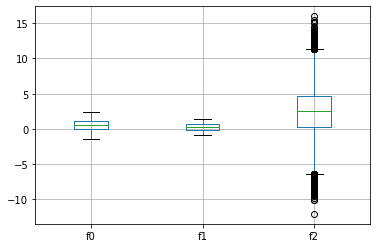

In [10]:
# строим диаграмму размаха для признаков первого региона

features_0.boxplot()


<AxesSubplot:>

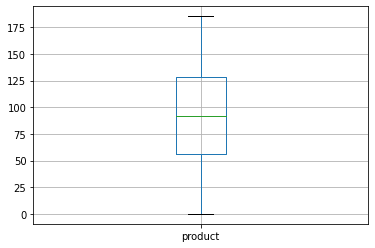

In [11]:
# а также для целевого признака первого региона

data_0.boxplot(column=['product'])

У значений признака f2 много вылетов(аномальных значений). Нужно уточнить у коллег, с чем связаны выбросы этого показателя и можно ли откинуть аномальные значения.

<AxesSubplot:>

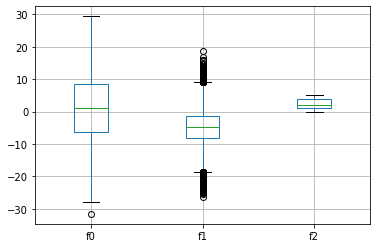

In [12]:
# строим диаграмму размаха для признаков второго региона

features_1.boxplot()

<AxesSubplot:>

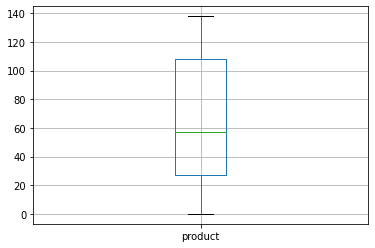

In [13]:
# а также для целевого признака второго региона

data_1.boxplot(column=['product'])

Значения целевого признака не имеют вылетов, а значения признаков f0 и f1 имеют вылеты. У f0 единичный вылет, у f1 - вылетов много. Нужно уточнить у коллег, с чем связаны выбросы этого показателя и можно ли откинуть аномальные значения.

<AxesSubplot:>

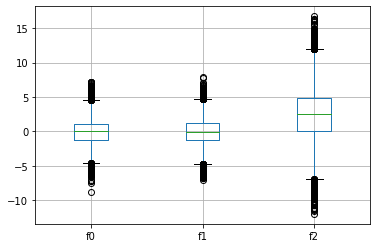

In [14]:
# строим диаграмму размаха для признаков третьего региона

features_2.boxplot()

<AxesSubplot:>

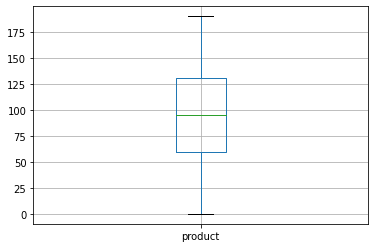

In [15]:
# а также для целевого признака третьего региона

data_2.boxplot(column=['product'])

Значения целевого признака без вылетов, а признаки все с вылетами. Построим тепловые карты для проверки мультиколлинеарности признаков.

<AxesSubplot:>

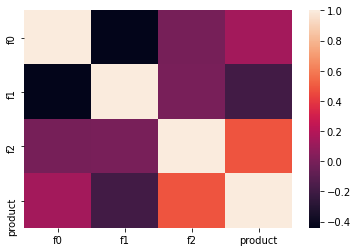

In [16]:
# построим тепловую карту для первого региона

sns.heatmap(data_0.corr())

Сильной корреляции между признаками не наблюдается.

<AxesSubplot:>

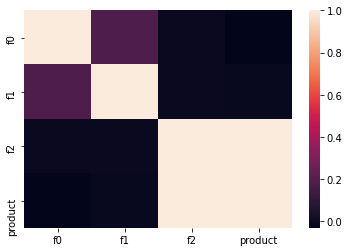

In [17]:
# построим тепловую карту для второго региона

sns.heatmap(data_1.corr())

Наблюдаем прямую сильную корреляцию между признаком f2 и целевым признаком. В будущем это может сказаться на модели. Уточним у коллег, с чем связана такая зависимость признаков.

<AxesSubplot:>

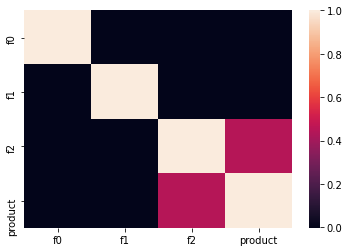

In [18]:
# построим тепловую карту для третьего региона

sns.heatmap(data_2.corr())

Сильной корреляции между признаками не наблюдается.

**Вывод** наблюдаются аномалии в значениях признаков, обратимся к коллегам для уточнения информации и вопросом, можно ли откинуть вылеты. Кроме этого, обнаружена прямая сильная корреляция между признаком f2 и целевым признаком во втором регионе. В будущем это может сказаться на модели. Уточним у коллег, с чем связана такая зависимость признаков.

## Обучение и проверка модели

In [19]:
# Разделим данные на обучающую и валидационную выборки в соотношении 75:25

def train_valid(features, target):
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state= 12345)
 
    return features_train, features_valid, target_train, target_valid

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_valid(features_0, target_0)


features_train_1, features_valid_1, target_train_1, target_valid_1 = train_valid(features_1, target_1)


features_train_2, features_valid_2, target_train_2, target_valid_2 = train_valid(features_2, target_2)

# проверим, как работает функция

features_train_0, features_valid_0, target_train_0, target_valid_0



(             f0        f1         f2
 27212  0.022450  0.951034   2.197333
 7866   1.766731  0.007835   6.436602
 62041  0.724514  0.666063   1.840177
 70185 -1.104181  0.255268   2.026156
 82230 -0.635263  0.747990   6.643327
 ...         ...       ...        ...
 4094   1.863680 -0.298123   1.621324
 85412 -1.162682 -0.014822   6.819941
 2177   0.862688 -0.403776   1.867662
 77285  0.846235 -0.489533   1.058786
 86498  2.019850  0.263887  11.497239
 
 [75000 rows x 3 columns],
              f0        f1        f2
 71751  0.948970 -0.057547  2.095727
 80493  0.992974  0.206671 -0.142278
 2655   1.199854 -0.563356 -1.852991
 53233  0.691422 -0.433347  0.564974
 91141  0.420772  0.972638  0.736190
 ...         ...       ...       ...
 12581  1.841106 -0.107678  2.585648
 18456  0.041859  0.489280  2.168001
 73035  0.376389  1.054298 -0.430104
 63834  1.071330 -0.470046  4.527099
 43558  1.726318 -0.077871  5.007083
 
 [25000 rows x 3 columns],
 27212    147
 7866     147
 62041     77


Суммарное количество обьектов соответствует первоначальным данным (75 000 + 25 000), значит разделение на выборки прошло успешно. Приступим к обучению модели. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые)

In [20]:
# обучим модель и сделаем предсказания на валидационной выборке

def train_model(features_train, target_train, features_valid):

    model_lr = LinearRegression()

    model_lr.fit(features_train, target_train)

    predictions_valid = model_lr.predict(features_valid)
    
    return pd.Series(predictions_valid).astype(int)

predictions_valid_0 = train_model(features_train_0, target_train_0, features_valid_0)

predictions_valid_1 = train_model(features_train_1, target_train_1, features_valid_1)

predictions_valid_2 = train_model(features_train_2, target_train_2, features_valid_2)

# проверим результат предсказаний модели первого региона

predictions_valid_0


0         95
1         77
2         77
3         89
4         70
        ... 
24995    102
24996     84
24997     61
24998    117
24999    117
Length: 25000, dtype: int64

In [21]:
# аналогично сохраним правильные ответы на валидационной выборке, изменив индексацию, чтобы совпадала с индексаций predictions_valid
    
def target_valid(target_valid):
    
    target_valid = pd.Series(target_valid).astype(int).reset_index(drop=True)
    
    return target_valid


target_valid_0 = target_valid(target_valid_0)

target_valid_1 = target_valid(target_valid_1)

target_valid_2 = target_valid(target_valid_2)

# проверяем, что получилось

target_valid_0

0         10
1        114
2        132
3        169
4        122
        ... 
24995    170
24996     93
24997    127
24998     99
24999    177
Name: product, Length: 25000, dtype: int64

Модель обучили и сделали предсказания на валидационной выборке, сохранили предсказания и правильные ответы на валидационной выборке.

Далее расчитаем средний запас предсказанного сырья и проверим качество модели.

In [22]:
# расчитаем и напечатаем на экране средний запас предсказанного сырья 

def middle_product_predicted(predictions_valid, n):
    
        middle_product_predicted = int(predictions_valid.mean())
          
        print(f'Средний запас предсказанного сырья региона {n}:', middle_product_predicted)
        
        return middle_product_predicted
    
middle_product_predicted_0 = middle_product_predicted(predictions_valid_0, 1)

middle_product_predicted_1 = middle_product_predicted(predictions_valid_1, 2)

middle_product_predicted_2 = middle_product_predicted(predictions_valid_2, 3)

print(middle_product_predicted_0)

print(middle_product_predicted_1)

print(middle_product_predicted_2)

Средний запас предсказанного сырья региона 1: 91
Средний запас предсказанного сырья региона 2: 67
Средний запас предсказанного сырья региона 3: 93
91
67
93


Средний запас предсказанного сырья составляет:

регион 1: 91 тыс баррелей

регион 2: 67 тыс баррелей

регион 3: 93 тыс баррелей

In [23]:
# проверяем качество (RMSE модели)

def rmse(target_valid, predictions_valid, n):
    
    rmse = mean_squared_error(target_valid, predictions_valid) ** 0.5
    
    print(f'RMSE модели для {n} региона:', rmse)
    
rmse_0 = rmse(target_valid_0, predictions_valid_0, 1)

rmse_1 = rmse(target_valid_1, predictions_valid_1, 2)

rmse_2 = rmse(target_valid_2, predictions_valid_2, 3)

RMSE модели для 1 региона: 37.58105214067323
RMSE модели для 2 региона: 1.153152201576184
RMSE модели для 3 региона: 40.03349147901042


На данных второго региона модель показывает наилучшее качество предсказания (RMSE значительно ниже, чем на других регионах).

Проанализируем, с чем это может быть связано. Проверим зависимость признаков друг от друга.

In [24]:
# проверяем корреляцию признаков первого региона

data_0[['f0', 'f1', 'f2', 'product']].corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Наибольшую прямую зависимость наблюдаем между параметрами f2 и целевым признаком, а наибольшая обратная зависимость между f1 и f0. Остальные зависимости не значительны.

In [25]:
# проверяем корреляцию признаков второго региона

data_1[['f0', 'f1', 'f2', 'product']].corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Наибольшую прямую зависимость наблюдаем между признаком f2 и целевым признаком, она составляет почти 1, то есть, это абсолютная зависимость целевого показателя от признака f2. Именно в связи с этим, модель так хорошо предсказывает, то есть она опирается на изменение значений признака f2.

In [26]:
# проверяем корреляцию признаков третьего региона

data_2[['f0', 'f1', 'f2', 'product']].corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Наибольшую прямую зависимость наблюдаем между параметрами f2 и целевым признаком. Остальные зависимости не значительны.

**Вывод** при обучении и проверке модели была выявлена разница в качестве модели для данных разных регионов. Поэтому, стоит обратиться к коллегам для выяснения причин прямой зависимости признака f2 и целевого признака во втором регионе, и почему в других регионах такой зависимости нет.

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 

In [27]:
nonrevenue_product = int(BUDGET / REVENUE_UNIT / COUNT)

nonrevenue_product

111

Для безубыточной разработки новой скважины необходимый средний объем сырья составляет 111 тыс баррелей.

In [28]:
# Сравним полученный объём сырья со средним запасом в каждом регионе

def compare_product(middle_product_predicted, n):
    
    if middle_product_predicted < nonrevenue_product:
        
        return(print(f'В регионе {n} недостаточный средний объем сырья для безубыточной разработки новой скважины'))
        
    elif middle_product_predicted == nonrevenue_product:
            
        return(print(f'В регионе {n}  средний объем сырья соответствует объему, необходимому для безубыточной разработки новой скважины'))
            
    else:
                
        return(print(f'В регионе {n}  средний объем сырья превышает объем, необходимый для безубыточной разработки новой скважины'))
        
        
compare_product_0 = compare_product(middle_product_predicted_0, 1)
compare_product_1 = compare_product(middle_product_predicted_1, 2)
compare_product_2 = compare_product(middle_product_predicted_2, 3)
                

В регионе 1 недостаточный средний объем сырья для безубыточной разработки новой скважины
В регионе 2 недостаточный средний объем сырья для безубыточной разработки новой скважины
В регионе 3 недостаточный средний объем сырья для безубыточной разработки новой скважины


**Вывод:** Получается, что в каждом регионе **средний** объем сырья недостаточен для безубыточной разработки новой скважины. Поэтому из 500 скважин будем выбирать 200 скважин с максимальными значениями предсказаний. 

## Расчёт прибыли и рисков 

In [29]:
#  Выберим 200 скважин с максимальными значениями предсказаний.

count = 200

def predictions_max(predictions_valid):
    
    predictions_sorted = predictions_valid.sort_values(ascending=False)
    
    selected = predictions_sorted[:count]
    
    selected = pd.Series(selected)
    
    return selected


predictions_max_0 =predictions_max(predictions_valid_0)

predictions_max_1 =predictions_max(predictions_valid_1)

predictions_max_2 =predictions_max(predictions_valid_2)

display(predictions_max_0) 

  

9317     179
10015    175
11584    175
219      175
4296     172
        ... 
12633    148
13551    147
21629    147
6433     147
20340    147
Length: 200, dtype: int64

In [30]:
#Просуммируем целевое значение объёма сырья, соответствующее предсказаниям

def sum_target(target_valid, predictions_max):
    
    target_predictions = target_valid[predictions_max.index]
    
    sum_target_predictions = target_predictions.sum()
    
    return sum_target_predictions


sum_target_predictions_0 = sum_target(target_valid_0, predictions_max_0)

sum_target_predictions_1 = sum_target(target_valid_1, predictions_max_1)

sum_target_predictions_2 = sum_target(target_valid_2, predictions_max_2)



# выведем значения на экран

def print_sum_target_predictions(sum_target_predictions, n):

    print(f'Сумма целевого значения объема сырья региона {n}, соответствующего максимальным предсказаниям, {sum_target_predictions} тыс баррелей')

print_sum_target_predictions_0 = print_sum_target_predictions(sum_target_predictions_0, 1)

print_sum_target_predictions_1 = print_sum_target_predictions(sum_target_predictions_1, 2)

print_sum_target_predictions_2 = print_sum_target_predictions(sum_target_predictions_2, 3)

Сумма целевого значения объема сырья региона 1, соответствующего максимальным предсказаниям, 29612 тыс баррелей
Сумма целевого значения объема сырья региона 2, соответствующего максимальным предсказаниям, 27397 тыс баррелей
Сумма целевого значения объема сырья региона 3, соответствующего максимальным предсказаниям, 28191 тыс баррелей


In [31]:
#Рассчитаем прибыль для полученного объёма сырья

def profit_selected(sum_target_predictions, n):
    
    profit_selected = REVENUE_UNIT * sum_target_predictions - BUDGET
    
    print(f'Целевая прибыль двухста скважин региона {n} с наилучшими предсказаниями, {profit_selected} руб') 
    
    return profit_selected

profit_selected_0 = profit_selected(sum_target_predictions_0, 1)

profit_selected_1 = profit_selected(sum_target_predictions_1, 2)

profit_selected_2 = profit_selected(sum_target_predictions_2, 3)

# выведем на экран

print(profit_selected_0)

print(profit_selected_1)

profit_selected_2

Целевая прибыль двухста скважин региона 1 с наилучшими предсказаниями, 3325400000 руб
Целевая прибыль двухста скважин региона 2 с наилучшими предсказаниями, 2328650000 руб
Целевая прибыль двухста скважин региона 3 с наилучшими предсказаниями, 2685950000 руб
3325400000
2328650000


2685950000

**Вывод:** Целевая прибыль двухста скважин региона 1 с наилучшими предсказаниями составляет более 3,3 млр руб (3 325 400 000 руб)

Целевая прибыль двухста скважин региона 2 с наилучшими предсказаниями составляет более 2,3 млрд руб (2 328 650 000 руб)

Целевая прибыль двухста скважин региона 3 с наилучшими предсказаниями составляет более 2,6 млрд руб ( 2 685 950 000 руб)

## **Расчет рисков и прибыли для каждого региона**

In [32]:
# для удобства запишем функцию для расчета прибыли в виде одной функции:

def profit_selected(predictions_valid, target_valid, count):
    
    predictions_sorted = predictions_valid.sort_values(ascending=False)
    
    predictions_max = predictions_sorted[:count] 
    
    target_predictions = target_valid[predictions_max.index]
    
    sum_target_predictions = target_predictions.sum()
    
    profit_selected = REVENUE_UNIT * sum_target_predictions - BUDGET
    
    return profit_selected
    

In [33]:
#Применим технику Bootstrap с 1000 выборками, чтобы найти распределение прибыли.

state = RandomState(12345)

def bootstrap(target_valid, predictions_valid):
    
    values = []

    for i in range(1000):
    
        product_subsample = target_valid.sample(n = 500, replace=True, random_state=state)
        
        prediction_valid_subsample = predictions_valid[product_subsample.index]
        
        values.append(profit_selected(prediction_valid_subsample, product_subsample, 200))
        
    return values

bootstrap_0 = bootstrap(target_valid_0, predictions_valid_0)

bootstrap_1 = bootstrap(target_valid_1, predictions_valid_1)

bootstrap_2 = bootstrap(target_valid_2, predictions_valid_2)

# перезапишем в формате Series
        
bootstrap_0 = pd.Series(bootstrap_0)

bootstrap_1 = pd.Series(bootstrap_1)

bootstrap_2 = pd.Series(bootstrap_2)

# проверим, как работает функция

bootstrap_0

0      910700000
1      450350000
2      514700000
3      547100000
4      252800000
         ...    
995    480500000
996    891350000
997    984500000
998    486350000
999    445850000
Length: 1000, dtype: int64

Посчитаем среднюю прибыль, 95%-й доверительный интервал и риски для каждого региона.

In [34]:
# средняя прибыль

def revenue_mean(bootstrap):
    
    revenue_mean = bootstrap.mean()
    
    return revenue_mean

revenue_mean_0 = revenue_mean(bootstrap_0) 

revenue_mean_1 = revenue_mean(bootstrap_1)

revenue_mean_2 = revenue_mean(bootstrap_2)


# выведем на экран среднюю прибыль

def print_revenue_mean(revenue_mean, n):
    
    print(f'Средняя прибыль региона {n}, рассчитанная техникой бустреп, составляет {revenue_mean} рублей')

print_revenue_mean_0 = print_revenue_mean(revenue_mean_0, 1) 

print_revenue_mean_1 = print_revenue_mean(revenue_mean_1, 2)

print_revenue_mean_2 = print_revenue_mean(revenue_mean_2, 3)

Средняя прибыль региона 1, рассчитанная техникой бустреп, составляет 554403050.0 рублей
Средняя прибыль региона 2, рассчитанная техникой бустреп, составляет 593886500.0 рублей
Средняя прибыль региона 3, рассчитанная техникой бустреп, составляет 552954950.0 рублей


In [35]:
# расчитаем доверительный интервал средней прибыли для каждого региона:

def confidence_interval(bootstrap, n):
    
    lower = int(bootstrap.quantile(0.025))
    
    upper = int(bootstrap.quantile(0.975))
    
    print(f'Доверительный интервал средней прибыли для региона {n} находится в диапазоне от {lower} до {upper} рублей')
    
    return lower, upper

    
confidence_interval_0 = confidence_interval(bootstrap_0, 1)   

confidence_interval_1 = confidence_interval(bootstrap_1, 2)

confidence_interval_2 = confidence_interval(bootstrap_2, 3)

print(confidence_interval_0)

print(confidence_interval_1)

print(confidence_interval_2)


Доверительный интервал средней прибыли для региона 1 находится в диапазоне от -20856249 до 1163228750 рублей
Доверительный интервал средней прибыли для региона 2 находится в диапазоне от 143360000 до 1113211250 рублей
Доверительный интервал средней прибыли для региона 3 находится в диапазоне от -36145000 до 1220761250 рублей
(-20856249, 1163228750)
(143360000, 1113211250)
(-36145000, 1220761250)


In [37]:
# расчитаем риск убытков для каждого региона

def peril_loss(bootstrap, n):

    print('Риск убытков = {:.2%} '.format((bootstrap<0).mean()))
    

peril_loss_0 = peril_loss(bootstrap_0, 1)

peril_loss_1 = peril_loss(bootstrap_1, 2)

peril_loss_2 = peril_loss(bootstrap_2, 3)


print(peril_loss_0)

print(peril_loss_1)

print(peril_loss_2)

Риск убытков = 3.40% 
Риск убытков = 0.50% 
Риск убытков = 3.50% 
None
None
None


У второго региона самая низкая вероятность убытков 0,5% и наибольшая средняя прибыль (более 593 млн руб). Именно этот регион предлагаем для разработки.

**Общий вывод:** 
Для выбора региона, где добыча принесёт наибольшую прибыль, была обучена модель для предсказания объема сырья.

На данных второго региона модель показала наилучшее качество предсказания (RMSE значительно ниже, чем на других регионах). Это произошло в связи с тем, что между признаком f2 и целевым признаком наблюдается абсолютная прямая зависимость. В связи с этим модель хорошо предсказывает, она опирается на изменение значений признака f2. 

Средний запас предсказанного сырья составляет:

регион 1: 91 тыс баррелей

регион 2: 67 тыс баррелей

регион 3: 93 тыс баррелей


Эти показатели оказались недостаточными для безубыточной разработки региона, поэтому, в дальнейшем были выбраны 200 скважин с максимальными значениями предсказаний. И на основе этих данных расчитана целевая прибыль:

1 регион -  более 3,3 млр руб (3 325 400 000 руб)

2 регион - более 2,3 млрд руб (2 328 650 000 руб)

3 регион - более 2,6 млрд руб ( 2 685 950 000 руб)

После этого техникой бустреп расчитана средняя прибыль, 95%-й доверительный интервал и риски для каждого региона.

**По результатам сделаны выводы, что у второго региона самая низкая вероятность убытков - 0,5% и наибольшая средняя прибыль (более 593 млн руб). Именно этот регион предлагаем для разработки**.

Хотелось бы добавить, что несмотря на то, что средний запас предсказанного сырья, а также целевая прибыль у второго региона имеют самые низкие показатели по сравнению с двумя другими регионами, выводы получились, наоборот, в пользу второго региона. Можно предположить, что это связано с тем, что в первом и третьем регионе помимо очень прибыльных скважин, есть и много убыточных скважин, попасть в которые вероятность, достаточно, высокая, в отличие от второго региона, где скважины распределены более равномерно - они хоть и имеют меньшие запасы предсказанного сырья, но зато имеют очень маленький процент убыточных.  

Также просим  коллег уточнить следующие моменты:

* обнаружены неявные дубликаты с повторяющимися id  по всех трех датафреймах.

* с чем связаны выбросы  показателей признаков и можно ли откинуть аномальные значения признаков (у значений признака f2 первого региона, у f1 второго региона, у всех признаков третьего региона много вылетов(аномальных значений).  

* каковы причины прямой сильной корреляции признака f2 и целевого признака во втором регионе, и почему в других регионах такой зависимости нет.